## **0. Download dataset**
**Note:** If you can't download using gdown due to limited number of downloads, please download it manually and upload it to your drive, then copy it from the drive to colab.
```python
from google.colab import drive

drive.mount('/content/drive')
!cp /path/to/dataset/on/your/drive .
```

## **1. Import libraries**

In [1]:
import torch
import torch.nn as nn
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 59
set_seed(seed)

## **2. Read dataset**

In [3]:
root_dir = '/kaggle/input/resnet-weather/weather-dataset/dataset'
classes = {
    label_idx: class_name \
        for label_idx, class_name in enumerate(
            sorted(os.listdir(root_dir))
        )
}

img_paths = []
labels = []
for label_idx, class_name in classes.items():
    class_dir = os.path.join(root_dir, class_name)
    for img_filename in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_filename)
        img_paths.append(img_path)
        labels.append(label_idx)

## **3. Train, val, test split**

In [4]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    img_paths, labels,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle
)

## **4. Create pytorch dataset**

In [5]:
class WeatherDataset(Dataset):
    def __init__(
        self,
        x, y,
        transform=None
    ):
        self.x = x
        self.y = y
        self.transform = transform

    def __len__(self):
        """Trả về số lượng mẫu trong dataset."""
        return len(self.x)

    def __getitem__(self, idx):
        """Trả về một mẫu dữ liệu (hình ảnh và nhãn)."""

        image = Image.open(self.x[idx]).convert("RGB")
        label = self.y[idx]
        if self.transform != None:
            image = self.transform(image)
        return image, label

## **5. Create data preprocessing function**

resize ảnh, đổi về tensor, chuyển dim và chuẩn hóa giá trị pixel về khoảng (0, 1).

In [6]:
def transform(img : Image.Image, img_size=(224, 224)):
    img = img.resize(img_size)
    img = np.array(img)
    # W-H-C --> C-H-W
    img = torch.Tensor(img).permute(2, 0, 1).float()
    img = img / 255.0
    return img

## **6. Create dataloader**

In [7]:
train_dataset = WeatherDataset(
    X_train, y_train,
    transform=transform
)
val_dataset = WeatherDataset(
    X_val, y_val,
    transform=transform
)
test_dataset = WeatherDataset(
    X_test, y_test,
    transform=transform
)

In [8]:
train_batch_size = 512
test_batch_size = 8

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)



Feature batch shape: torch.Size([512, 3, 224, 224])
Labels batch shape: torch.Size([512])


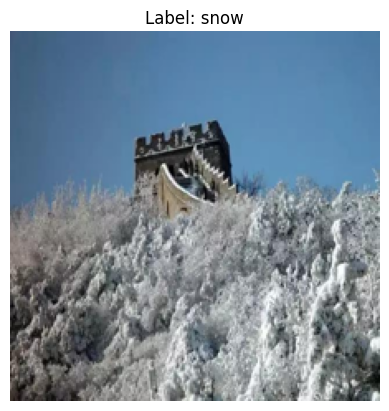

In [9]:
train_features, train_labels = next(iter(train_loader))
print(f'Feature batch shape: {train_features.size()}')
print(f'Labels batch shape: {train_labels.size()}')
img = train_features[0].permute(1, 2, 0)
label = train_labels[0].item()
plt.imshow(img)
plt.axis('off')
plt.title(f'Label: {classes[label]}')
plt.show()

## **7. Create model**

In [10]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=stride, padding=1)
        self.norm_1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        self.norm_2 = nn.BatchNorm2d(out_channels)

        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels : 
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels,
                          kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        self.relu = nn.ReLU()
    def forward(self, x):
        shorcut = x.clone()
        x = self.conv1(x)
        x = self.norm_1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.norm_2(x)
        x = self.relu(x)
        x = x + self.downsample(shorcut)
        x = self.relu(x)
        return x

In [11]:
class ResNet(nn.Module):
    def __init__(self, residual_block, n_blocks_lst, n_classes):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3)
        self.norm_1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer2 = self.create_layer(residual_block, 64, 64, n_blocks_lst[0], stride=1)
        self.layer3 = self.create_layer(residual_block, 64, 128, n_blocks_lst[1], stride=2)
        self.layer4 = self.create_layer(residual_block, 128, 256, n_blocks_lst[2], stride=2)
        self.layer5 = self.create_layer(residual_block, 256, 512, n_blocks_lst[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512, n_classes)

    def create_layer(self, residual_block, in_channels, out_channels, n_blocks, stride):
        blocks = []
        first_block = residual_block(in_channels, out_channels, stride)
        blocks.append(first_block)

        for i in range(1, n_blocks):
            blocks.append(residual_block(out_channels, out_channels, stride=stride))
        
        # giải nén [block1, block2] -> block1, block2
        return nn.Sequential(*blocks)

    def forward(self, x):
        x = self.conv1(x)
        x = self.norm_1(x)
        x = self.maxpool1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc1(x)
    
        return x

In [12]:
n_classes = len(list(classes.keys()))
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = ResNet(
    residual_block=ResidualBlock,
    n_blocks_lst=[2, 2, 2, 2],
    n_classes=n_classes
).to(device)

In [13]:
model.eval()

dummy_tensor = torch.randn(1, 3, 224, 224).to(device)

with torch.no_grad():
    output = model(dummy_tensor)

print('Output shape:', output.shape)

Output shape: torch.Size([1, 11])


## **8. Training**

In [14]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = sum(losses) / len(losses)
    acc = correct / total

    return loss, acc

In [15]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs
):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []

        model.train()
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(
            model, val_loader,
            criterion, device
        )
        val_losses.append(val_loss)

        print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}')

    return train_losses, val_losses

In [16]:
lr = 1e-2
epochs = 25

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=lr
)

In [17]:
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs
)

EPOCH 1:	Train loss: 1.8805	Val loss: 2.4015
EPOCH 2:	Train loss: 1.2976	Val loss: 2.3989
EPOCH 3:	Train loss: 1.0411	Val loss: 2.3022
EPOCH 4:	Train loss: 0.8593	Val loss: 1.9437
EPOCH 5:	Train loss: 0.6946	Val loss: 1.4290
EPOCH 6:	Train loss: 0.5924	Val loss: 1.2516
EPOCH 7:	Train loss: 0.5158	Val loss: 1.4343
EPOCH 8:	Train loss: 0.4018	Val loss: 1.0792
EPOCH 9:	Train loss: 0.2936	Val loss: 1.0680
EPOCH 10:	Train loss: 0.2485	Val loss: 1.0975
EPOCH 11:	Train loss: 0.1882	Val loss: 0.9781
EPOCH 12:	Train loss: 0.1420	Val loss: 0.9892
EPOCH 13:	Train loss: 0.1108	Val loss: 1.0027
EPOCH 14:	Train loss: 0.0890	Val loss: 0.9568
EPOCH 15:	Train loss: 0.0749	Val loss: 0.9884
EPOCH 16:	Train loss: 0.0601	Val loss: 0.9628
EPOCH 17:	Train loss: 0.0502	Val loss: 0.9666
EPOCH 18:	Train loss: 0.0443	Val loss: 0.9674
EPOCH 19:	Train loss: 0.0398	Val loss: 0.9487
EPOCH 20:	Train loss: 0.0364	Val loss: 0.9678
EPOCH 21:	Train loss: 0.0314	Val loss: 0.9616
EPOCH 22:	Train loss: 0.0282	Val loss: 0.96

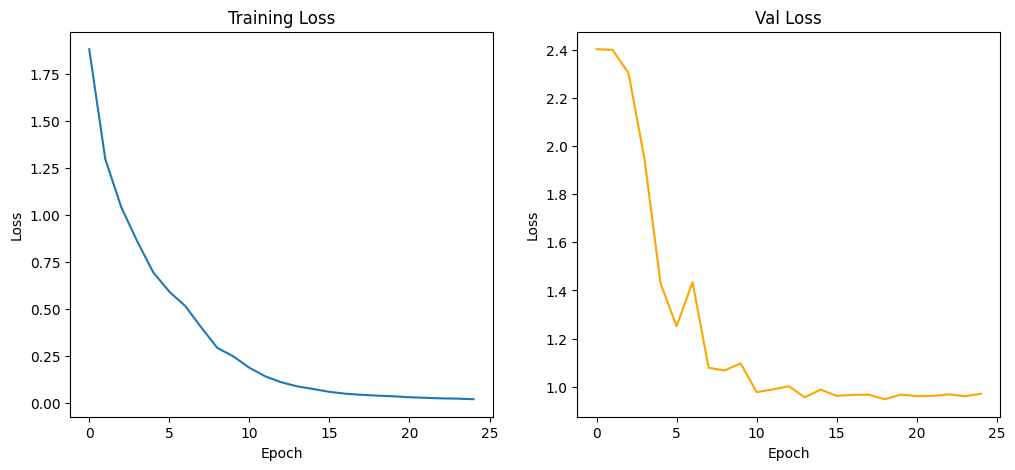

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(train_losses)
ax[0].set_title('Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(val_losses, color='orange')
ax[1].set_title('Val Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.show()

## **9. Evaluation**

In [19]:
val_loss, val_acc = evaluate(
    model,
    val_loader,
    criterion,
    device
)
test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion,
    device
)

print('Evaluation on val/test dataset')
print('Val accuracy: ', val_acc)
print('Test accuracy: ', test_acc)

Evaluation on val/test dataset
Val accuracy:  0.6882738528769119
Test accuracy:  0.7003642987249544
